
Per-run, per-district vote counts and efficiency gaps:

=== Election Run 1 ===
 District 0: Party counts = [45 50 30]
    Wasted votes difference (efficiency gap) = -66
 District 1: Party counts = [49 37 39]
    Wasted votes difference (efficiency gap) = -68
 District 2: Party counts = [39 37 49]
    Wasted votes difference (efficiency gap) = -68
 District 3: Party counts = [43 41 41]
    Wasted votes difference (efficiency gap) = -80
 District 4: Party counts = [41 53 31]
    Wasted votes difference (efficiency gap) = -60
 District 5: Party counts = [44 36 45]
    Wasted votes difference (efficiency gap) = -76
 District 6: Party counts = [42 40 43]
    Wasted votes difference (efficiency gap) = -80
 District 7: Party counts = [37 38 50]
    Wasted votes difference (efficiency gap) = -66

=== Election Run 2 ===
 District 0: Party counts = [39 46 40]
    Wasted votes difference (efficiency gap) = -74
 District 1: Party counts = [35 42 48]
    Wasted votes difference (efficiency gap) = 

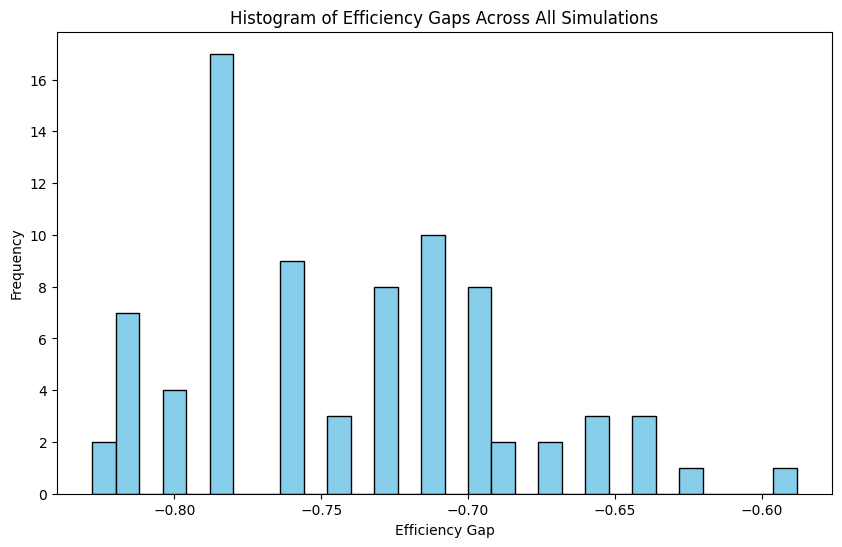

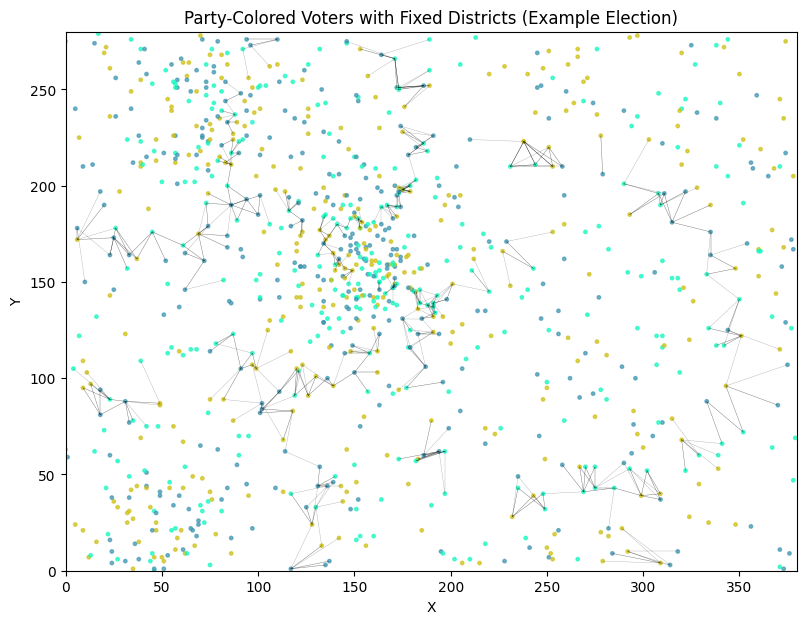

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# ------------------------
# Parameters
# ------------------------
WIDTH = 380
HEIGHT = 280
NUM_VOTERS = 1000

NUM_PARTIES = 3
NUM_DISTRICTS = 8
VOTERS_PER_DISTRICT = NUM_VOTERS // NUM_DISTRICTS

NUM_CITIES = 5
CITY_INTENSITY = (5, 12)
CITY_SPREAD = (10, 30)

NUM_RUNS = 10  # number of elections to simulate

np.random.seed(1)

# ------------------------
# Generate population density
# ------------------------
density = np.full((HEIGHT, WIDTH), 1.0)
X, Y = np.meshgrid(np.arange(WIDTH), np.arange(HEIGHT))

for _ in range(NUM_CITIES):
    cx = np.random.uniform(0, WIDTH)
    cy = np.random.uniform(0, HEIGHT)
    intensity = np.random.uniform(*CITY_INTENSITY)
    sigma = np.random.uniform(*CITY_SPREAD)
    density += intensity * np.exp(
        -((X - cx)**2 + (Y - cy)**2) / (2 * sigma**2)
    )

# ------------------------
# Sample voters
# ------------------------
flat = density.flatten()
probs = flat / flat.sum()
indices = np.random.choice(len(flat), size=NUM_VOTERS, p=probs)
ys, xs = np.divmod(indices, WIDTH)
voters = np.column_stack((xs, ys))

# ------------------------
# Connected district generation (BFS region growing)
# ------------------------
def connected_districts(voters, num_districts, voters_per_district, k_neighbors=20):
    N = len(voters)
    district = -np.ones(N, dtype=int)
    tree = cKDTree(voters)
    unassigned = set(range(N))

    for d in range(num_districts):
        if not unassigned:
            break

        seed = np.random.choice(list(unassigned))
        district[seed] = d
        unassigned.remove(seed)

        queue = [seed]
        count = 1

        while queue and count < voters_per_district:
            current = queue.pop(0)
            _, neighbors = tree.query(voters[current], k=k_neighbors)
            for n in neighbors:
                if n in unassigned:
                    district[n] = d
                    unassigned.remove(n)
                    queue.append(n)
                    count += 1
                    if count >= voters_per_district:
                        break

        if count < voters_per_district:
            # reset and restart if failed
            for i in range(N):
                if district[i] == d:
                    district[i] = -1
                    unassigned.add(i)
            return connected_districts(voters, num_districts, voters_per_district)

    return district

# Generate districts once
district_labels = connected_districts(voters, NUM_DISTRICTS, VOTERS_PER_DISTRICT)

# ------------------------
# Prepare party colors
# ------------------------
party_colors = np.random.rand(NUM_PARTIES, 3)

# ------------------------
# Simulate multiple elections
# ------------------------
results = np.zeros((NUM_RUNS, NUM_DISTRICTS, NUM_PARTIES), dtype=int)
efficiency_gaps = np.zeros((NUM_RUNS, NUM_DISTRICTS))

for run in range(NUM_RUNS):
    voter_parties = np.random.randint(0, NUM_PARTIES, size=NUM_VOTERS)
    
    # Count votes per district
    for d in range(NUM_DISTRICTS):
        mask = district_labels == d
        counts = np.bincount(voter_parties[mask], minlength=NUM_PARTIES)
        results[run, d, :] = counts
        
        # Efficiency gap calculation
        total_votes = counts.sum()
        winner_votes = counts.max()
        loser_votes = total_votes - winner_votes
        wasted_winner = winner_votes - (total_votes / 2)
        wasted_loser = loser_votes
        efficiency_gaps[run, d] = (wasted_winner - wasted_loser) / total_votes





# ------------------------
# Summary statistics for each run and each district
# ------------------------
print("\nPer-run, per-district vote counts and efficiency gaps:")

for run in range(NUM_RUNS):
    print(f"\n=== Election Run {run + 1} ===")
    for d in range(NUM_DISTRICTS):
        # Votes per party in this district, as integers
        district_votes = results[run, d, :].astype(int)
        print(f" District {d}: Party counts = {district_votes}")

        # Efficiency gap for this district (integer version)
        # Wasted votes for each party
        total_votes = district_votes.sum()
        winning_party_idx = np.argmax(district_votes)
        winning_votes = district_votes[winning_party_idx]
        losing_votes = total_votes - winning_votes

        wasted_winner = winning_votes - (total_votes // NUM_PARTIES)
        wasted_loser = losing_votes

        efficiency_gap = wasted_winner - wasted_loser
        print(f"    Wasted votes difference (efficiency gap) = {efficiency_gap}")

'''

# ------------------------
# Summary statistics
# ------------------------
avg_votes = results.mean(axis=0)
print("\nAverage votes per district across all runs:")
for d in range(NUM_DISTRICTS):
    print(f" District {d}: {avg_votes[d]}")

avg_efficiency = efficiency_gaps.mean(axis=0)
print("\nAverage efficiency gap per district across all runs:")
for d in range(NUM_DISTRICTS):
    print(f" District {d}: {avg_efficiency[d]:.4f}")

overall_eff = efficiency_gaps.mean()
print(f"\nOverall average efficiency gap across all districts and runs: {overall_eff:.4f}")
'''
# ------------------------
# Histogram of efficiency gaps
# ------------------------
plt.figure(figsize=(10,6))
plt.hist(efficiency_gaps.flatten(), bins=30, edgecolor='black', color='skyblue')
plt.xlabel("Efficiency Gap")
plt.ylabel("Frequency")
plt.title("Histogram of Efficiency Gaps Across All Simulations")
plt.show()

# ------------------------
# Plot voters with fixed district boundaries (for first election)
# ------------------------
first_run_parties = np.random.randint(0, NUM_PARTIES, size=NUM_VOTERS)
first_run_colors = party_colors[first_run_parties]

plt.figure(figsize=(10,7))
plt.scatter(voters[:,0], voters[:,1], c=first_run_colors, s=6, alpha=0.7)

# Draw district boundary lines
tree = cKDTree(voters)
for i in range(len(voters)):
    distances, neighbors = tree.query(voters[i], k=8)
    for n in neighbors:
        if district_labels[i] != district_labels[n]:
            plt.plot(
                [voters[i,0], voters[n,0]],
                [voters[i,1], voters[n,1]],
                color='black', linewidth=0.3, alpha=0.3
            )

plt.title(f"Party-Colored Voters with Fixed Districts (Example Election)")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(0, WIDTH)
plt.ylim(0, HEIGHT)
plt.gca().set_aspect("equal")
plt.show()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# ------------------------
# Parameters
# ------------------------
WIDTH = 380
HEIGHT = 280
NUM_VOTERS = 1000

NUM_PARTIES = 3
NUM_DISTRICTS = 8
VOTERS_PER_DISTRICT = NUM_VOTERS // NUM_DISTRICTS

NUM_CITIES = 5
CITY_INTENSITY = (5, 12)
CITY_SPREAD = (10, 30)

NUM_RUNS = 10  # number of redistrictings to simulate

np.random.seed(1)

# ------------------------
# Generate population density
# ------------------------
density = np.full((HEIGHT, WIDTH), 1.0)
X, Y = np.meshgrid(np.arange(WIDTH), np.arange(HEIGHT))

for _ in range(NUM_CITIES):
    cx = np.random.uniform(0, WIDTH)
    cy = np.random.uniform(0, HEIGHT)
    intensity = np.random.uniform(*CITY_INTENSITY)
    sigma = np.random.uniform(*CITY_SPREAD)
    density += intensity * np.exp(
        -((X - cx)**2 + (Y - cy)**2) / (2 * sigma**2)
    )

# ------------------------
# Sample voters (FIXED)
# ------------------------
flat = density.flatten()
probs = flat / flat.sum()
indices = np.random.choice(len(flat), size=NUM_VOTERS, p=probs)
ys, xs = np.divmod(indices, WIDTH)
voters = np.column_stack((xs, ys))

# ------------------------
# Assign fixed party preferences
# ------------------------
voter_parties = np.random.randint(0, NUM_PARTIES, size=NUM_VOTERS)

# ------------------------
# Connected district generation (retry-safe)
# ------------------------
def connected_districts(voters, num_districts, voters_per_district, k_neighbors=20, max_attempts=20):
    N = len(voters)
    tree = cKDTree(voters)

    for attempt in range(max_attempts):

        district = -np.ones(N, dtype=int)
        unassigned = set(range(N))
        success = True

        for d in range(num_districts):

            if not unassigned:
                break

            seed = np.random.choice(list(unassigned))
            district[seed] = d
            unassigned.remove(seed)

            queue = [seed]
            count = 1

            while queue and count < voters_per_district:
                current = queue.pop(0)
                _, neighbors = tree.query(voters[current], k=k_neighbors)

                for n in neighbors:
                    if n in unassigned:
                        district[n] = d
                        unassigned.remove(n)
                        queue.append(n)
                        count += 1
                        if count >= voters_per_district:
                            break

            if count < voters_per_district:
                success = False
                break

        if success:
            return district

    raise RuntimeError("Failed to generate connected districts.")

# ------------------------
# Storage
# ------------------------
results = np.zeros((NUM_RUNS, NUM_DISTRICTS, NUM_PARTIES), dtype=int)
efficiency_gaps = np.zeros((NUM_RUNS, NUM_DISTRICTS))

# ------------------------
# Simulate random redistricting ensemble
# ------------------------
for run in range(NUM_RUNS):

    # Generate new neutral district map
    district_labels = connected_districts(
        voters,
        NUM_DISTRICTS,
        VOTERS_PER_DISTRICT
    )

    for d in range(NUM_DISTRICTS):

        mask = district_labels == d
        counts = np.bincount(
            voter_parties[mask],
            minlength=NUM_PARTIES
        )

        results[run, d, :] = counts

        total_votes = counts.sum()
        winner_votes = counts.max()
        loser_votes = total_votes - winner_votes

        wasted_winner = winner_votes - (total_votes / 2)
        wasted_loser = loser_votes

        efficiency_gaps[run, d] = (
            wasted_winner - wasted_loser
        ) / total_votes

# ------------------------
# Print summary
# ------------------------
print("\nPer-run, per-district vote counts and efficiency gaps:")

for run in range(NUM_RUNS):
    print(f"\n=== Redistricting Run {run + 1} ===")
    for d in range(NUM_DISTRICTS):

        district_votes = results[run, d, :]
        print(f" District {d}: Party counts = {district_votes}")

        total_votes = district_votes.sum()
        winning_votes = district_votes.max()
        losing_votes = total_votes - winning_votes

        wasted_winner = winning_votes - (total_votes / 2)
        wasted_loser = losing_votes
        gap = (wasted_winner - wasted_loser) / total_votes

        print(f"    Efficiency gap = {gap:.4f}")

# ------------------------
# Histogram of efficiency gaps
# ------------------------
plt.figure(figsize=(10,6))
plt.hist(efficiency_gaps.flatten(), bins=30, edgecolor='black', color='skyblue')
plt.xlabel("Efficiency Gap")
plt.ylabel("Frequency")
plt.title("Histogram of Efficiency Gaps Across Random Redistrictings")
plt.show()

# ------------------------
# Visualize final district map
# ------------------------
party_colors = np.random.rand(NUM_PARTIES, 3)
voter_colors = party_colors[voter_parties]

plt.figure(figsize=(10,7))
plt.scatter(voters[:,0], voters[:,1], c=voter_colors, s=6, alpha=0.7)

tree = cKDTree(voters)

for i in range(len(voters)):
    _, neighbors = tree.query(voters[i], k=8)
    for n in neighbors:
        if district_labels[i] != district_labels[n]:
            plt.plot(
                [voters[i,0], voters[n,0]],
                [voters[i,1], voters[n,1]],
                color='black', linewidth=0.3, alpha=0.3
            )

plt.title("Example Random District Map (Final Run)")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(0, WIDTH)
plt.ylim(0, HEIGHT)
plt.gca().set_aspect("equal")
plt.show()


RuntimeError: Failed to generate connected districts.